In [1]:
# izracunati fingerprints, izbaciti kojima je varijanca 0, ubaciti u model, usporediti rezultate s prijasnjima

# XGBoost regression model - 2d deskriptori, fingerprints

In [1]:
import sys
sys.path.append('../src')
from modules import *
from funkcije import calculate_fingerprint

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_csv('../../data/solubility_all_new_data.csv', index_col=0)

In [3]:
# Pretvaranje SMILES iz DataFrame-a u listu molekula
smiles_list = data['smiles'].to_list()

# Paralelno izračunavanje otisaka molekula
with concurrent.futures.ThreadPoolExecutor() as executor:
    fps = list(executor.map(calculate_fingerprint, smiles_list))

# 'fps' sada sadrži otiske svih valjanih molekula
for fp in fps[:10]:  # Ispis prvih 10 otisaka 
    print(fp)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


In [59]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.01)
selector.fit(fps)
reduced_data = selector.transform(fps)
reduced_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [60]:
# Pretvaranje liste otisaka u DataFrame
fp_df = pd.DataFrame(fps)
print(data.shape, fp_df.shape)

(3351, 7) (3351, 1024)


In [61]:
removed_features = [column for column in fp_df.columns 
                     if column not in fp_df.columns[selector.get_support()]]
removed_features

[6,
 12,
 17,
 20,
 22,
 30,
 38,
 43,
 44,
 47,
 48,
 50,
 56,
 60,
 62,
 63,
 66,
 76,
 78,
 87,
 93,
 98,
 100,
 103,
 107,
 108,
 111,
 122,
 131,
 132,
 137,
 142,
 143,
 148,
 149,
 151,
 152,
 153,
 154,
 155,
 159,
 161,
 162,
 166,
 167,
 168,
 172,
 173,
 174,
 176,
 177,
 178,
 181,
 183,
 187,
 188,
 189,
 196,
 198,
 201,
 206,
 211,
 213,
 215,
 217,
 218,
 220,
 223,
 229,
 230,
 238,
 241,
 246,
 248,
 254,
 257,
 260,
 261,
 265,
 267,
 269,
 273,
 277,
 280,
 286,
 287,
 291,
 292,
 297,
 300,
 302,
 303,
 306,
 307,
 313,
 317,
 318,
 321,
 323,
 330,
 331,
 337,
 340,
 344,
 347,
 355,
 359,
 363,
 365,
 368,
 372,
 373,
 374,
 382,
 383,
 384,
 385,
 388,
 395,
 399,
 400,
 402,
 405,
 409,
 410,
 415,
 427,
 434,
 437,
 438,
 442,
 443,
 445,
 447,
 449,
 454,
 457,
 462,
 465,
 466,
 467,
 472,
 474,
 476,
 477,
 480,
 483,
 491,
 495,
 496,
 499,
 503,
 505,
 509,
 513,
 514,
 515,
 516,
 517,
 518,
 530,
 532,
 536,
 538,
 539,
 542,
 543,
 544,
 545,
 553,
 55

In [62]:
# Izračunajte varijancu za svaku kolonu
#variances = fp_df.var()

# Pronađite kolone koje imaju varijancu veću od 1e-2
#high_variance_cols = variances[variances > 0.01].index
#print(high_variance_cols)

# Filtrirajte podatke da zadržite samo te kolone
#fp_df=fp_df[high_variance_cols]

In [63]:
# Spajanje otisaka s originalnim podacima
final_data = pd.concat([data, fp_df], axis=1)

In [64]:
final_data.to_csv('../../data/solubility_features.csv')

In [65]:
train_set,test_set=train_test_split(final_data,test_size=.2,random_state=42) 
train_set.shape, test_set.shape

((2680, 1031), (671, 1031))

In [66]:
features = final_data.columns[3:]
target = 'Solubility'

# Podijela podataka na skupove za treniranje, validaciju i testiranje
X_train, X_test, y_train, y_test = train_test_split(final_data[features], final_data[target], test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Treniranje XGBoost modela s ranom zaustavom
model = xgb.XGBRegressor(n_estimators=110, learning_rate=0.15, max_depth=8)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)

# Predviđanje na testnom skupu
y_pred = model.predict(X_test)

# Izračunavanje srednjekvadratne pogreške
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

# Izračunavanje R2 koeficijenta determinacije
r2 = r2_score(y_test, y_pred)
print('R2 Score:', r2)

Mean Squared Error: 1.1167944435034856
R2 Score: 0.7544871660960668


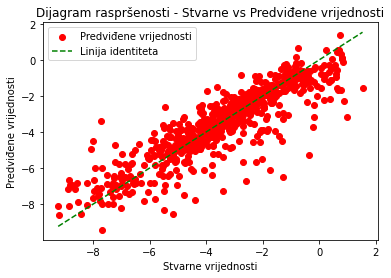

In [67]:
# Predviđanje na testnom skupu
y_pred = model.predict(X_test)

# Plotanje dijagrama raspršenosti
plt.scatter(y_test, y_pred, c='red', label='Predviđene vrijednosti')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='green', label='Linija identiteta')
plt.xlabel('Stvarne vrijednosti')
plt.ylabel('Predviđene vrijednosti')
plt.title('Dijagram raspršenosti - Stvarne vs Predviđene vrijednosti')

plt.legend()
plt.show()

In [68]:
# Definirajte raspon vrijednosti za parametre koje želite optimizirati
param_grid = {
    'n_estimators': [100, 110],
    'learning_rate': [0.05, 0.15],
    'max_depth': [5, 8]
}

# Inicijalizirajte model koji želite optimizirati
model = xgb.XGBRegressor()

# Inicijalizirajte pretraživač po rešetci s modelom i parametrima
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Izvršite pretraživanje po rešetci na podacima za treniranje
grid_search.fit(X_train, y_train)

# Ispišite najbolje kombinacije parametara
print("Najbolji parametri:", grid_search.best_params_)

# Trenirajte model s najboljim parametrima na cijelom skupu za treniranje
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Predviđanje na testnom skupu
y_pred = best_model.predict(X_test)

# Izračunavanje srednjekvadratne pogreške
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

# Izračunavanje R2 koeficijenta determinacije
r2 = r2_score(y_test, y_pred)
print('R2 Score:', r2)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Najbolji parametri: {'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 100}
Mean Squared Error: 1.1676934253133688
R2 Score: 0.7432976823556509
